# Preliminary
---
Import libraries, disable warnings, and define helper functions.

In [695]:
# Import libraries
from statsmodels.formula.api import ols
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from kagglehub.exceptions import KaggleApiHTTPError
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.utils import resample
import sklearn.metrics as metrics
from enum import Enum
from numpy import median
import statsmodels.api as sm
from statsmodels.tools.eval_measures import meanabs as mae, mse

In [696]:
def ridge_bootstrap(X, y, fixed_data, given_model=None, y_hat=[], interval="confidence", add_noise=False):
    n_bootstraps = 1000
    y_bootstrap = []
    for _ in range(n_bootstraps):
        X_resample, y_resample = resample(X, y)
        model = Ridge(alpha=1.0)
        model.fit(X_resample, y_resample)

        pred = model.predict(fixed_data)

        if interval == "prediction" and add_noise:
            # Add noise from residuals, simulating real observations
            y_resample_pred = model.predict(X_resample)
            residual_std = np.std(y_resample - y_resample_pred)
            noisy_pred = pred + np.random.normal(0, residual_std, size=pred.shape)
            y_bootstrap.append(noisy_pred)
        else:
            y_bootstrap.append(pred)

    y_bootstrap = np.array(y_bootstrap)

    if not add_noise and (interval == "prediction" and given_model is not None and len(y_hat) > 0):
        # Calculate PI with residual variance and without noise
        model_variance = np.var(y_bootstrap, axis=0, ddof=1)
        
        y_train_pred = given_model.predict(X)
        residuals = y - y_train_pred
        sigma_squared = np.var(residuals, ddof=1)
        total_variance = model_variance + sigma_squared
        
        z = 1.96

        interval_lower = y_hat - z * np.sqrt(total_variance)
        interval_upper = y_hat + z * np.sqrt(total_variance)
        return interval_lower, interval_upper

    interval_lower = np.percentile(y_bootstrap, 2.5, axis=0)
    interval_upper = np.percentile(y_bootstrap, 97.5, axis=0)
    return interval_lower, interval_upper

In [697]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance, 4))
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [698]:
def find_optimal_breakpoint(x, y, min_points=10):
    """
    Try all possible split points, and return the one that minimizes total RSS (residual sum of squares).
    """
    # Sort x in a logical order.
    x_sorted = x.sort_values().reset_index(drop=True)
    possible_splits = x_sorted[min_points:-min_points]

    best_rss = float('inf')
    best_break = None

    for split in possible_splits:
        # Split the data:
        # Left segment: x[mask], y[mask]
        # Right segment: x[~mask], y[~mask]
        mask = x < split
        if mask.sum() < min_points or (~mask).sum() < min_points:
            continue
        
        # Left segment
        model_left = sm.OLS(y[mask], sm.add_constant(x[mask])).fit()
        rss_left = np.sum(model_left.resid ** 2)

        # Right segment
        model_right = sm.OLS(y[~mask], sm.add_constant(x[~mask])).fit()
        rss_right = np.sum(model_right.resid ** 2)

        # Get the smallest residual sum of squares
        total_rss = rss_left + rss_right

        if total_rss < best_rss:
            best_rss = total_rss
            best_break = split

    return best_break


# Exploratory Analysis
---
1. Receive dataset and convert categorical (yes/no) variables into dummy variables.
2. Observe summary statistics.
3. Assess normality of dataset.

In [699]:
# Load the latest version
dataset_paths = [
  "rakeshkapilavai/extrovert-vs-introvert-behavior-data",
  # "shalmamuji/personality-prediction-data-introvert-extrovert"
]

for i, path in enumerate(dataset_paths):
  try:
    ea_df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      path,
      "personality_dataset.csv"
    )
  except KaggleApiHTTPError:
    print("Dataset unavailable online. Loading local copy.")
    ea_df = pd.read_csv("~/.cache/kagglehub/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data/versions/2/personality_dataset.csv")

# Store dataframe to be used in other notebooks
%store ea_df

ea_df

/var/folders/xj/5m3dhh594lb1gv6r95wws5nm0000gn/T/ipykernel_16389/420106784.py:9: DeprecationWarning:

load_dataset is deprecated and will be removed in a future version.



Stored 'ea_df' (DataFrame)


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2895,3.0,No,7.0,6.0,No,6.0,6.0,Extrovert
2896,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
2897,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
2898,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


In [700]:
# Get dimension of dataset
print(ea_df.shape)

# Check for na count
print(ea_df.isna().sum())

# Print summary statistics
ea_df.describe()

(2900, 8)
Time_spent_Alone             63
Stage_fear                   73
Social_event_attendance      62
Going_outside                66
Drained_after_socializing    52
Friends_circle_size          77
Post_frequency               65
Personality                   0
dtype: int64


,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,2837.000000,2838.000000,2834.000000,2823.000000,2835.000000
mean,4.505816,3.963354,3.000000,6.268863,3.564727
std,3.479192,2.903827,2.247327,4.289693,2.926582
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,3.000000,1.000000
50%,4.000000,3.000000,3.000000,5.000000,3.000000
75%,8.000000,6.000000,5.000000,10.000000,6.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


## Visualize Data
### Distribution of Personality Types
There were more extroverts than introverts in the datasets, with extroverts making up ~1500 of participants and introverts making up the other ~1400.

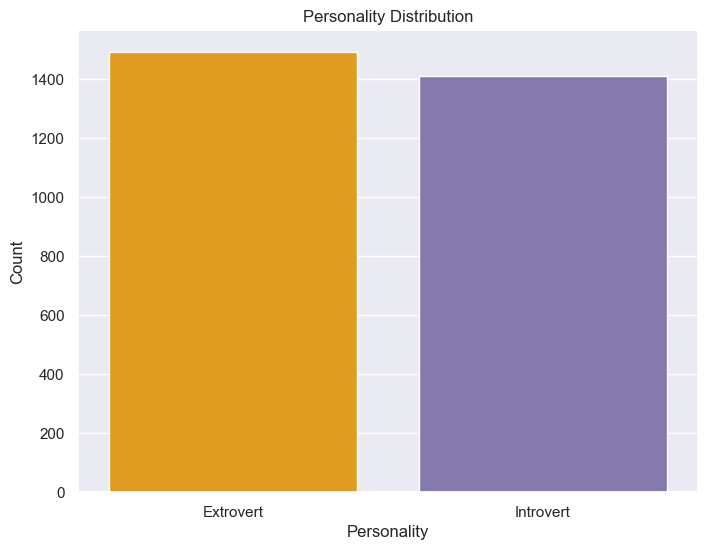

In [701]:
sns.set_theme(style="darkgrid")
palette = {"Extrovert": "orange", "Introvert": "m"}

plt.figure(figsize=(8, 6))
sns.countplot(
    x="Personality",
    data=ea_df,
    palette=palette,
    hue="Personality",
    legend=False
)
plt.title("Personality Distribution")
plt.xlabel("Personality")
plt.ylabel("Count")
plt.show()

### Feature Distributions
Both groups (extrovert & introvert) are clearly different. However, there are more outliers in the introvert group, suggesting that some "introvert" individuals shared some extrovert features. Also notice that for social event attendance, friend circle size, and post frequency, the introvert boxplot appear to be more left-skewed and have a lower average.

In [702]:
numericals = [
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency",
]

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        "Time Spent alone by Personality",
        "Social Event Attendence by Personality",
        "Going Outside by Personality",
        "Friend Circle by Personality",
        "Post Frequency by Personality"
    )
)

fig.add_trace(go.Box(x=ea_df["Personality"], y=ea_df["Time_spent_Alone"]), row=1, col=1)
fig.add_trace(go.Box(x=ea_df["Personality"], y=ea_df["Social_event_attendance"]), row=1, col=2)
fig.add_trace(go.Box(x=ea_df["Personality"], y=ea_df["Going_outside"]), row=2, col=1)
fig.add_trace(go.Box(x=ea_df["Personality"], y=ea_df["Friends_circle_size"]), row=2, col=2)
fig.add_trace(go.Box(x=ea_df["Personality"], y=ea_df["Post_frequency"]), row=3, col=1)

fig.update_layout(
    height=600, width=800,
    title_text="Boxplots of Numericals by Personality"
)
fig.show()

<img src="plots/boxplots.png" />

### Correlation Heatmap

Using the correlation heatmap, we can see that the features with the lowest positive correlation are friend circle size and post frequency. This makes sense as social media participation is not necessarily an introverted nor extroverted activity. It is still a strong correlation, where those with larger friend circle sizes tend to post more to interact with their friends. However, more introverted individuals may have similar rates of post frequency due to activity on larger forums or social media, without necessarily having a large friend circle size. This may explain the presence of outliers in the post frequency boxplot above.

In [703]:
fig = px.imshow(
    ea_df[numericals].corr(),
    labels=dict(x="Features", color="Correlation"),
    x=numericals,
    y=numericals,
    text_auto='.2f',
    aspect="auto"
)
fig.update_xaxes(side="top")
# fig.show()

<img src="plots/heatmap.png" />

In [704]:
numericals = [
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency",
]

fig = px.scatter_matrix(
    ea_df,
    dimensions=numericals,
    color="Personality",
    symbol="Personality",
    title="Scatter matrix of Numerical Features against Personality",
    labels={col:col.replace('_', ' ') for col in ea_df.columns},
    width=1000,
    height=1000,
)
fig.update_traces(diagonal_visible=True)
fig.show()

<img src="plots/scatter_matrix.png" />

## Frequency Distribution
The survey scales, when combined into a histogram, indicate that low responses (1.0 - 5.0) are more common than the upper response scales. The frequency distribution shows a positive skew towards 15 (highest scale value), indicating that these features are not normally distributed. This will affect the regression analysis.

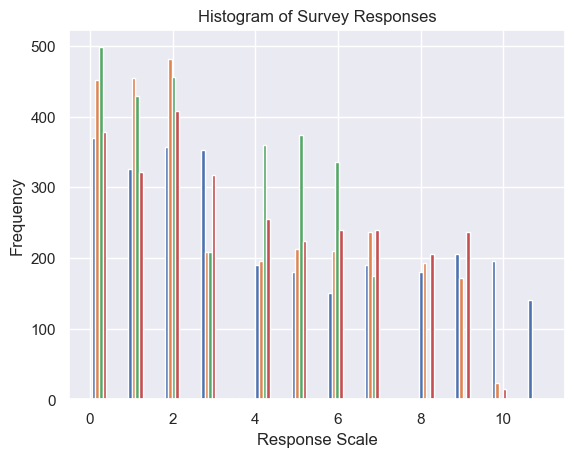

In [705]:
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

numericals = ea_df[predictors]

# for predictor in predictors:
#     numericals[predictor] = numericals[predictor] / max(numericals[predictor])


plt.hist(numericals, bins=25)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")
plt.show()

# Preprocessing
---
1. Impute numerical values with their column mean.
2. Impute categorical values with the most common in their column.
3. Create dummy variables of categorical columns.
4. Remove `no` columns and rename `yes` columns.

## Imputation

In [706]:
# Receive dataframe from ExploratoryAnalysis
%store -r ea_df

pre_df = ea_df.copy()
orig_pre_df = pre_df.copy()

# Impute numericals
numericals = [
    "Time_spent_Alone",
    "Social_event_attendance",
    "Going_outside",
    "Friends_circle_size",
    "Post_frequency",
]
pre_df[numericals] = pre_df[numericals].fillna(pre_df[numericals].mean())
print(pre_df[numericals].isna().sum())

# Impute categoricals
categoricals = [
    "Stage_fear",
    "Drained_after_socializing",
    "Personality"
]

pre_df[categoricals] = pre_df[categoricals].fillna(pre_df[categoricals].mode().iloc[0])
print(pre_df[categoricals].isna().sum())

Time_spent_Alone           0
Social_event_attendance    0
Going_outside              0
Friends_circle_size        0
Post_frequency             0
dtype: int64
Stage_fear                   0
Drained_after_socializing    0
Personality                  0
dtype: int64


## Create Dummy Variables for Categorical Variables

In [707]:
# Get dummy variables as False=0 and True=1
dummy_vars = pd.get_dummies(pre_df, dtype=int)
# Drop no categories
dummy_vars = dummy_vars.drop(["Stage_fear_No", "Drained_after_socializing_No"], axis="columns")
# Replace dataframe
pre_df = dummy_vars

pre_df = pre_df.rename(columns={
    "Stage_fear_Yes": "Stage_fear",
    "Drained_after_socializing_Yes": "Drained_after_socializing"
})

In [708]:
# Store and export processed dataframe
%store pre_df
pre_df.to_csv("data/preprocessing_dataframe.csv")
pre_df

Stored 'pre_df' (DataFrame)


,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency,Stage_fear,Drained_after_socializing,Personality_Extrovert,Personality_Introvert
0,4.0,4.0,6.0,13.0,5.0,0,0,1,0
1,9.0,0.0,0.0,0.0,3.0,1,1,0,1
2,9.0,1.0,2.0,5.0,2.0,1,1,0,1
3,0.0,6.0,7.0,14.0,8.0,0,0,1,0
4,3.0,9.0,4.0,8.0,5.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2895,3.0,7.0,6.0,6.0,6.0,0,0,1,0
2896,3.0,8.0,3.0,14.0,9.0,0,0,1,0
2897,4.0,1.0,1.0,4.0,0.0,1,1,0,1
2898,11.0,1.0,3.0,2.0,0.0,1,1,0,1


## Transform Data
The data is not normally distributed and will need to be transformed in some way. We can scale predictors as proportions $\frac{x}{max(x)}$, as each predictor has a different survey scale range (0-5, 0-7, 0-11, etc). Or we can apply natural log or square root operations to each predictor.

In [709]:
# Apply transformation to each variable

def transform(dataframe):
    for column in predictors:
        # Get proportion of responses.
        dataframe[column] = dataframe[column] / max(pre_df[column])

        # Apply log transform
        # dataframe[column] = np.where(dataframe[column] > 0, np.log(dataframe[column]), np.nan)

        # Apply square root transformation
        # dataframe[column] = np.sqrt(dataframe[column])

### (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [710]:
class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return pre_df[pre_df["Personality"] == personality.value[0]]
    return pre_df

pre_df = switch_personality()

# Linear Regression Analysis
---
**Research question**: "How many friends does a person have based on how much time they spend alone, post online, and whether they go outside and attend social events?"

I want to estimate how many friends a person may have based on time spent alone, how often they post online, and whether they attend social events when going outside (interaction).

$y = Friend\ Circle\ Size$

$\beta_0 = Intercept$

$\beta_1 = Time\ spent\ alone$

$\beta_2 = Post\ frequency$

$\beta_3 = Going\ outside$

$\beta_4 = Social\ event\ attendance$

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_x + \beta_4x_4$$

**NOTE:**
- Each survey item scale may be normally distributed, but when combined may form a non-normally distributed dataset.
    - We care about the error term being normally distributed ($\epsilon \sim N(0, \sigma^2))$.
    - We can standardize the survey scales to be proportions: $\frac{x}{max(x)}$

In [711]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
transform(pre_df)

In [712]:
train_df = pre_df.sample(frac=0.8, random_state=1863)
# transform(train_df)
test_df = pre_df.drop(train_df.index)
# transform(test_df)

### Observe Frequency Distribution

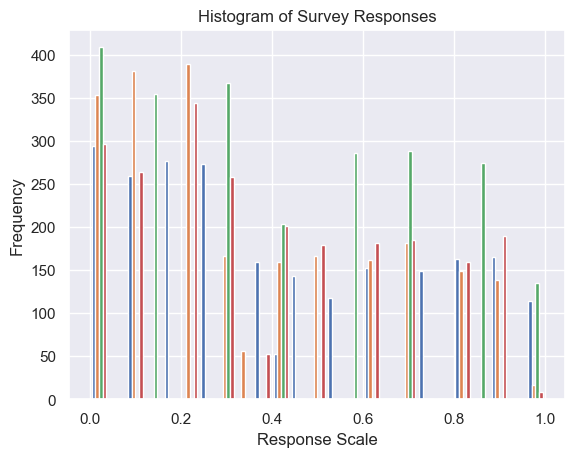

In [713]:
scales = train_df[predictors]

plt.hist(scales, bins=25)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")
plt.show()

## Manual Linear Regression

In [714]:
# See: https://ayoakin.medium.com/linear-regression-from-scratch-using-matrices-991df6e28f62

'''
X = train_df[predictors].copy()
X["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]
y = train_df[["Friends_circle_size"]].copy()

# Append column of 1s
X["Intercept"] = 1

# Transpose
X_T = X.T

# Calculate beta 1 using matrix form
B = np.linalg.inv(X_T @ X) @ (X_T @ y)

B.index = X.columns

# Compute predictions of y-hat using beta 1
predictions = X @ B

# Calculate Sum of Squares
SSR = ((y - predictions) ** 2).sum()
# Calculate Sum of Squares total
SST = ((y - y.mean()) ** 2).sum()
# Calculate R^2
R2 = 1 - (SSR / SST)

residuals = y - predictions

print("\nR-Squared: {}".format(R2.iloc[0]))
B, residuals.head()
'''

'\nX = train_df[predictors].copy()\nX["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]\ny = train_df[["Friends_circle_size"]].copy()\n\n# Append column of 1s\nX["Intercept"] = 1\n\n# Transpose\nX_T = X.T\n\n# Calculate beta 1 using matrix form\nB = np.linalg.inv(X_T @ X) @ (X_T @ y)\n\nB.index = X.columns\n\n# Compute predictions of y-hat using beta 1\npredictions = X @ B\n\n# Calculate Sum of Squares\nSSR = ((y - predictions) ** 2).sum()\n# Calculate Sum of Squares total\nSST = ((y - y.mean()) ** 2).sum()\n# Calculate R^2\nR2 = 1 - (SSR / SST)\n\nresiduals = y - predictions\n\nprint("\nR-Squared: {}".format(R2.iloc[0]))\nB, residuals.head()\n'

## Linear Regression using `statsmodels`

In [715]:
transformed_df = train_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
]]


model = ols(
    formula='Friends_circle_size ~ Time_spent_Alone + Post_frequency + Going_outside + Social_event_attendance',
    data=transformed_df
).fit()

## Predict Using Test Dataframe

In [716]:
test_df_prediction = test_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Personality"
]]

# Combine scaled test data with predictions
test_df_prediction['Predicted'] = model.predict(test_df_prediction)

In [717]:
y_predicted = test_df_prediction["Predicted"]
y_true = train_df["Friends_circle_size"].iloc[:len(y_predicted)]
print("MAE: {}".format(mae(y_true, y_predicted)))
print("MSE: {}".format(mse(y_true, y_predicted)))
model.summary()

MAE: 4.27378281410055
MSE: 27.80325718028963


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     1005.
Date:                 Sun, 27 Jul 2025   Prob (F-statistic):               0.00
Time:                         17:30:47   Log-Likelihood:                -5472.2
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2315   BIC:                         1.098e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.5178      0.235     14.973      0.000       3.057       3.979
Time_spent_Alone           -2.7947      0.279    -10.034      0.000      -3.341      -2.249
Post_frequency              2.1949      0.316      6.952      0.000       1.576       2.814
Going_outside               3.3598      0.296     11.364      0.000       2.780       3.940
Social_event_attendance     4.1512      0.311     13.349      0.000       3.541       4.761
==============================================================================
Omnibus:                       32.134   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.529
Skew:                           0.260   Prob(JB):                     1.42e-07
Kurtosis:                       2.762   Cond. No.                         9.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot regression model

### OLS Linear Regression with CI and PI
Plot OLS linear regression for each predictor against friend circle size with confidence and predictor intervals.

**NOTE:** Because each predictor influences each other when plotting data points, a linear space of data between the min and max of each predictor was needed to be generated. Additionally, each of the other predictors need to be held constant. This means that this test data is synthetic, but is used for model visualization and is not integrated into the test and train samples.

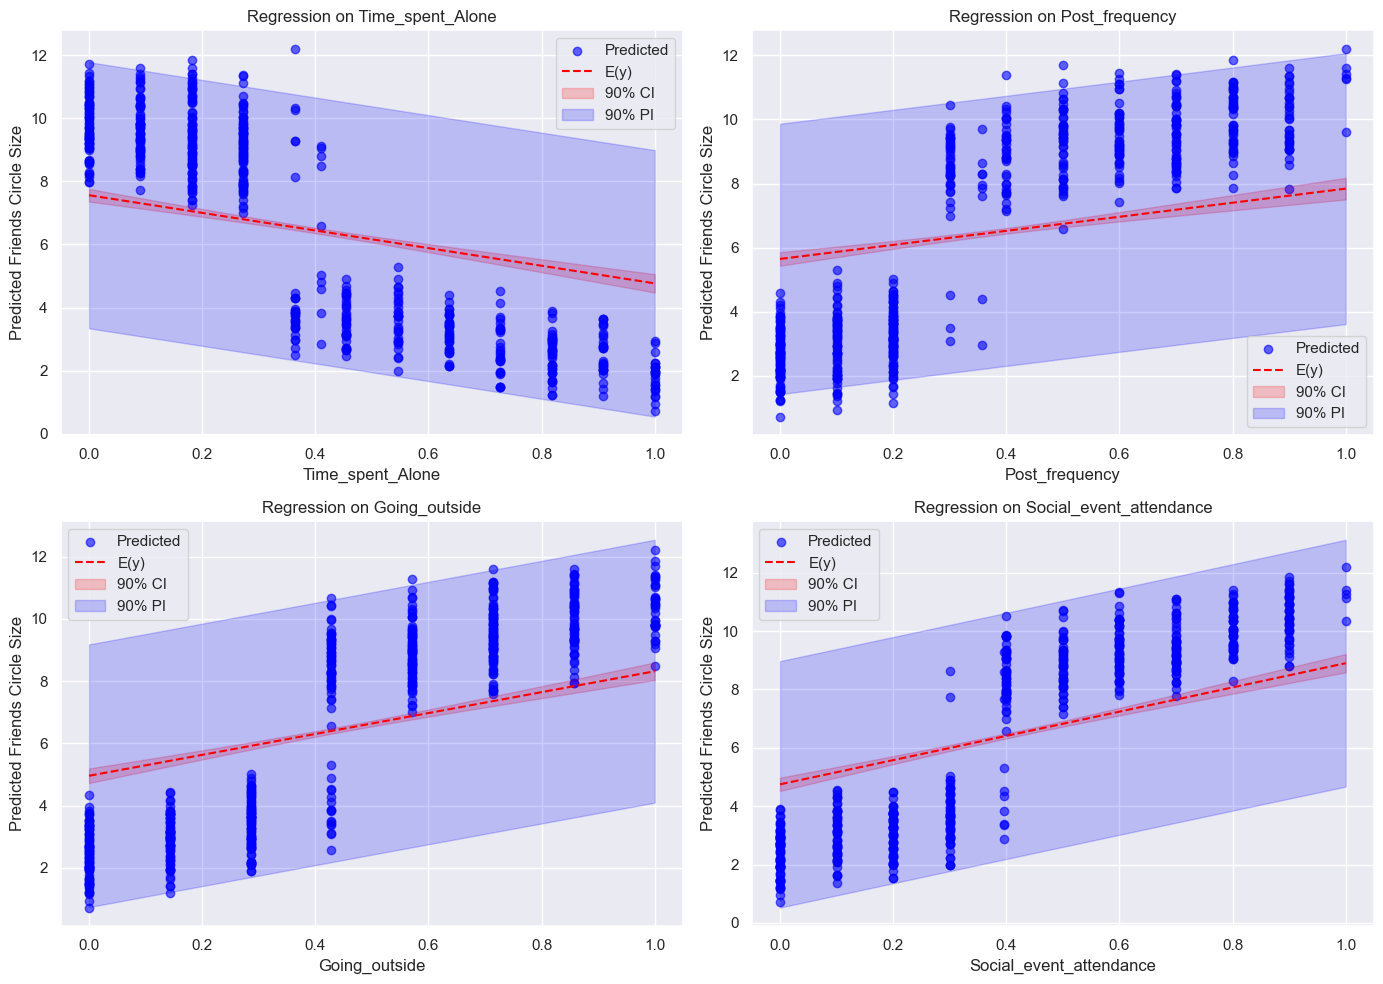

In [718]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]

    # Isolate effects of each predictor and hold other predictors constant (at mean).
    # Generate synthetic data within bounds of predictor; used for testing model
    # Hold all else equal
    x_vals = np.linspace(test_df_prediction[predictor].min(), test_df_prediction[predictor].max(), 100)

    # Create a DataFrame with mean values for other predictors
    fixed_data = pd.DataFrame({
        col: [test_df_prediction[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })
    # fixed_data = fixed_data[predictors]  # Ensure column order

    pred = model.get_prediction(fixed_data)
    pred_summary = pred.summary_frame(alpha=0.10)

    # Plot points
    ax.scatter(
        test_df_prediction[predictor],
        test_df_prediction["Predicted"],
        color="blue",
        alpha=0.6,
        label="Predicted"
    )

    # Regression Line
    ax.plot(
        x_vals,
        pred_summary['mean'],
        color='red',
        label='E(y)',
        linestyle='--'
    )

    # Confidence interval
    ax.fill_between(
        x_vals,
        pred_summary['mean_ci_lower'],
        pred_summary['mean_ci_upper'],
        color='red',
        alpha=0.2,
        label='90% CI'
    )

    # Prediction interval
    ax.fill_between(
        x_vals,
        pred_summary['obs_ci_lower'],
        pred_summary['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='90% PI'
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.legend()

plt.tight_layout()
plt.show()

#### Determine Fitness of Residuals

Residual standard error: 2.559387725978477


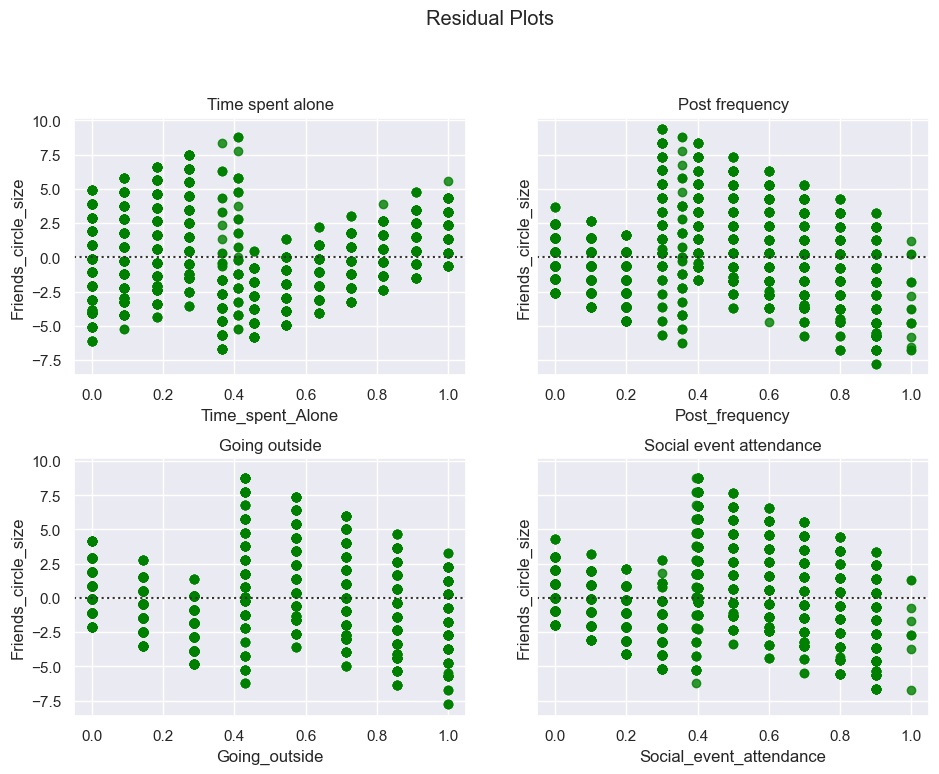

In [719]:
residuals = model.resid

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle("Residual Plots")
fig.tight_layout(pad=3.0)

plots_info = [
    {
        "name": "Time_spent_Alone",
        "title": "Time spent alone",
        "axes": (0, 0)
    },
    {
        "name": "Post_frequency",
        "title": "Post frequency",
        "axes": (0, 1)
    },
    {
        "name": "Going_outside",
        "title": "Going outside",
        "axes": (1, 0)
    },
    {
        "name": "Social_event_attendance",
        "title": "Social event attendance",
        "axes": (1, 1)
    }
]

print("Residual standard error: {}".format(np.std(residuals)))

for plot in plots_info:
    y_axis = plot["axes"][0]
    x_axis = plot["axes"][1]
    position = axes[y_axis, x_axis]
    sns.residplot(transformed_df, x=plot["name"], y="Friends_circle_size", ax=position, color="green")
    position.set_title(plot["title"])

### Segmented Linear Regression

#### Find Optimal Breakpoints for Each Predictor

In [720]:
# Create empty dataframe with predictors as columns and first row filled with NA
breakpoints = pd.DataFrame(np.nan, columns=predictors, index=[1])

# Fill first row with optimal breakpoints.
for predictor in predictors:
    breakpoints[predictor] = find_optimal_breakpoint(test_df_prediction[predictor], test_df_prediction["Predicted"])

breakpoints

,Time_spent_Alone,Post_frequency,Going_outside,Social_event_attendance
1,0.363636,0.3,0.428571,0.4


#### Plot Segmented Regressions with CI & PI

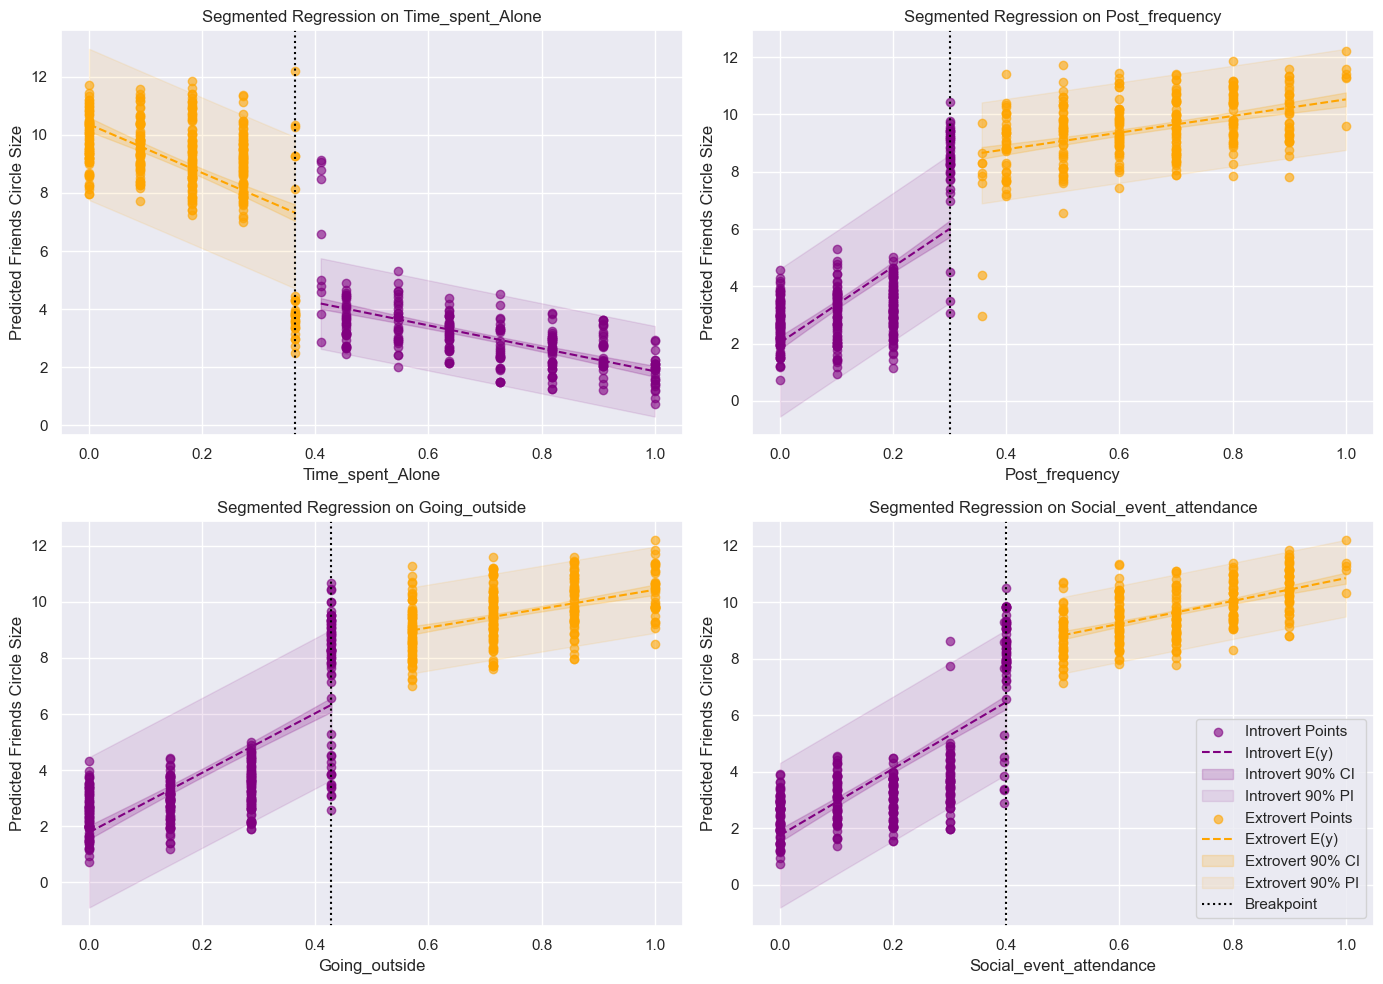

In [721]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

segments = {
    1: {
        "label": Personality.extrovert.value[1],
        "color": "orange"
    },
    0: {
        "label": Personality.introvert.value[1],
        "color": "purple"
    }
}

for i, predictor in enumerate(predictors):
    ax = axs[i]
    bp = breakpoints[predictor][1]

    # Split dataset at breakpoint
    low_mask = test_df_prediction[predictor] <= bp
    high_mask = test_df_prediction[predictor] > bp

    for mask in [low_mask, high_mask]:
        segment_data = test_df_prediction[mask]
        X = segment_data[[predictor]].copy()
        X = sm.add_constant(X)
        y = segment_data["Predicted"]

        model_seg = sm.OLS(y, X).fit()

        # Generate x values in this segment range
        x_vals = np.linspace(X[predictor].min(), X[predictor].max(), 100)
        X_plot = pd.DataFrame({predictor: x_vals})
        X_plot = sm.add_constant(X_plot)

        pred = model_seg.get_prediction(X_plot)
        pred_summary = pred.summary_frame(alpha=0.10)

        # Determine the most common personality type, labeling and coloring as assigned
        personality = segment_data["Personality"].mode()[0]

        # Plot actual points in this segment
        ax.scatter(
            segment_data[predictor],
            segment_data["Predicted"],
            alpha=0.6,
            color=segments[personality]["color"],
            label=f"{segments[personality]['label']} Points"
        )

        # Plot regression line
        ax.plot(
            x_vals,
            pred_summary['mean'],
            color=segments[personality]["color"],
            linestyle='--',
            label=f'{segments[personality]['label']} E(y)'
        )

        # Confidence interval
        ax.fill_between(
            x_vals,
            pred_summary['mean_ci_lower'],
            pred_summary['mean_ci_upper'],
            color=segments[personality]["color"],
            alpha=0.2,
            label=f'{segments[personality]['label']} 90% CI'
        )

        # Prediction interval
        ax.fill_between(
            x_vals,
            pred_summary['obs_ci_lower'],
            pred_summary['obs_ci_upper'],
            color=segments[personality]["color"],
            alpha=0.1,
            label=f'{segments[personality]['label']} 90% PI'
        )

    ax.set_title(f'Segmented Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.axvline(bp, color='black', linestyle=':', label='Breakpoint')

plt.legend()
plt.tight_layout()
plt.show()

### Multicollinearity
Parameters are collinear:
- `Going_outside` = `Social_event_attendance` = `Post_frequency`

## Prediction

In [722]:
column_range: dict[str, dict[ str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(orig_pre_df[column]),
        "median": median(orig_pre_df[column]),
        "min": min(orig_pre_df[column])
    }

In [723]:
B = model.params
B_df = pd.DataFrame(index=B.index, data=B.values, columns=["Coefficient"])
B_df.to_csv("./data/coefficient_dataframe.csv")

def estimate(x, idx):
    coefficient: float = B.iloc[idx]
    proportion: float = x / column_range[B.index[idx]]["max"]
    return coefficient * proportion

time_alone = lambda x: estimate(x, 1)
post_freq = lambda x: estimate(x, 2)
outside = lambda x: estimate(x, 3)
events = lambda x: estimate(x, 4)
outside_event_attendance = lambda x: estimate(x, 5)

y = time_alone(1) + post_freq(5) + outside(10) + events(10)
y

np.float64(9.794280982612115)

# Ridge Regression
---

## Prepare Dataframe

In [724]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
transform(pre_df)

In [725]:
transformed_df = pre_df.copy()[predictors]


## Ridge Regression Modeling

In [726]:
X = transformed_df
y = pre_df['Friends_circle_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

# Alpha controls strength of L2 regularization
ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.601
mean_squared_log_error:  0.2159
r2:  0.6008
MAE:  2.1236
MSE:  6.8794
RMSE:  2.6229


Regularization parameter $\lambda$ may be difficult to choose. If it is too small, then the model overfits to the training data (similar to OLS). If it is to large, the the model becomes too simple, leading to underfitting.

### Ridge Cross-Validation

In [727]:
X = transformed_df
y = pre_df['Friends_circle_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

from sklearn.linear_model import RidgeCV
# Alpha controls strength of L2 regularization
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_cv_model = RidgeCV(alphas=alphas, store_cv_results=True).fit(X_train, y_train)

# NOTE: tradeoff between prediction and model calibration due to squeezing of variance
# Elastic net

y_pred = ridge_cv_model.predict(X_test)
print(f"Optimal lambda: {ridge_cv_model.alpha_}")
regression_results(y_test, y_pred)

Optimal lambda: 1.0
explained_variance:  0.601
mean_squared_log_error:  0.2159
r2:  0.6008
MAE:  2.1236
MSE:  6.8794
RMSE:  2.6229


## Plot Ridge Regresion with CI & PI
Included are the residual plots for each of the predictor variables.

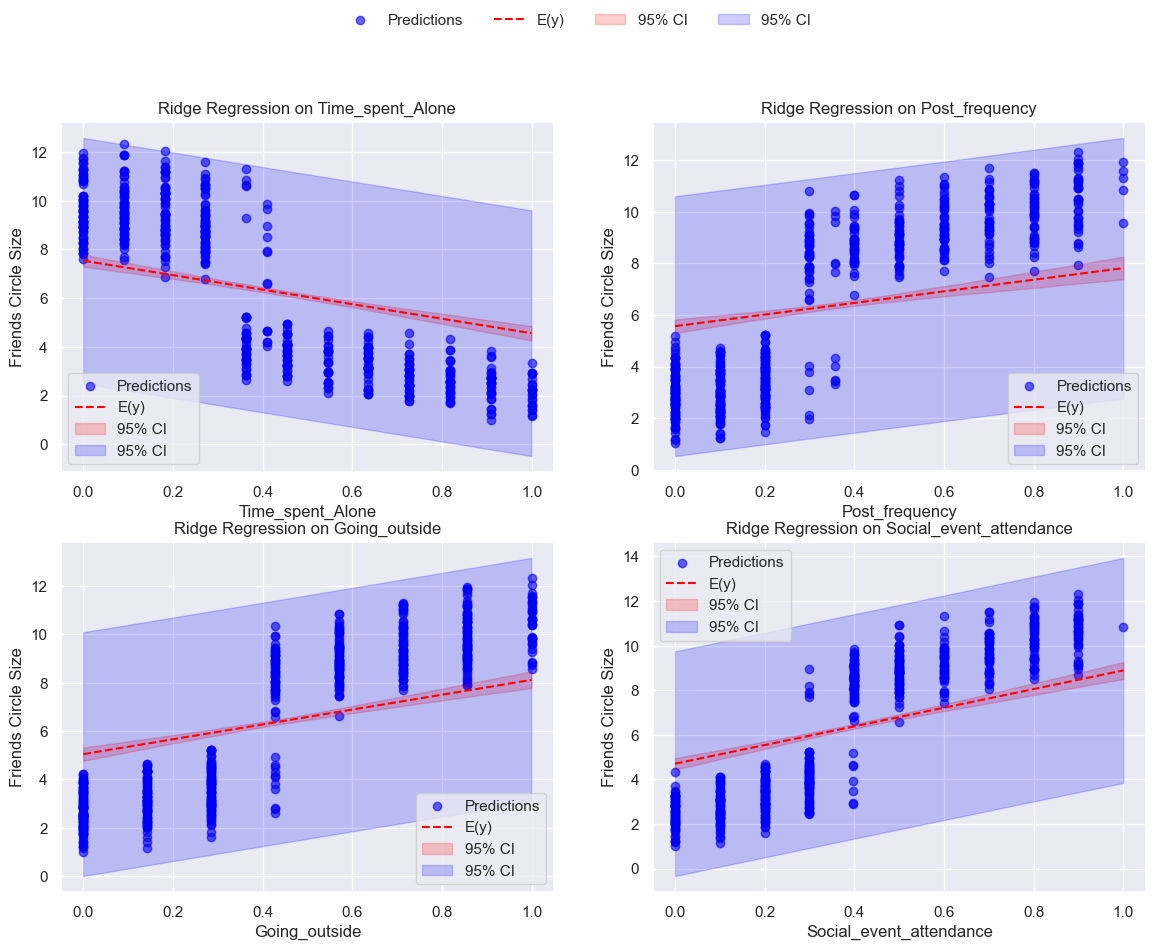

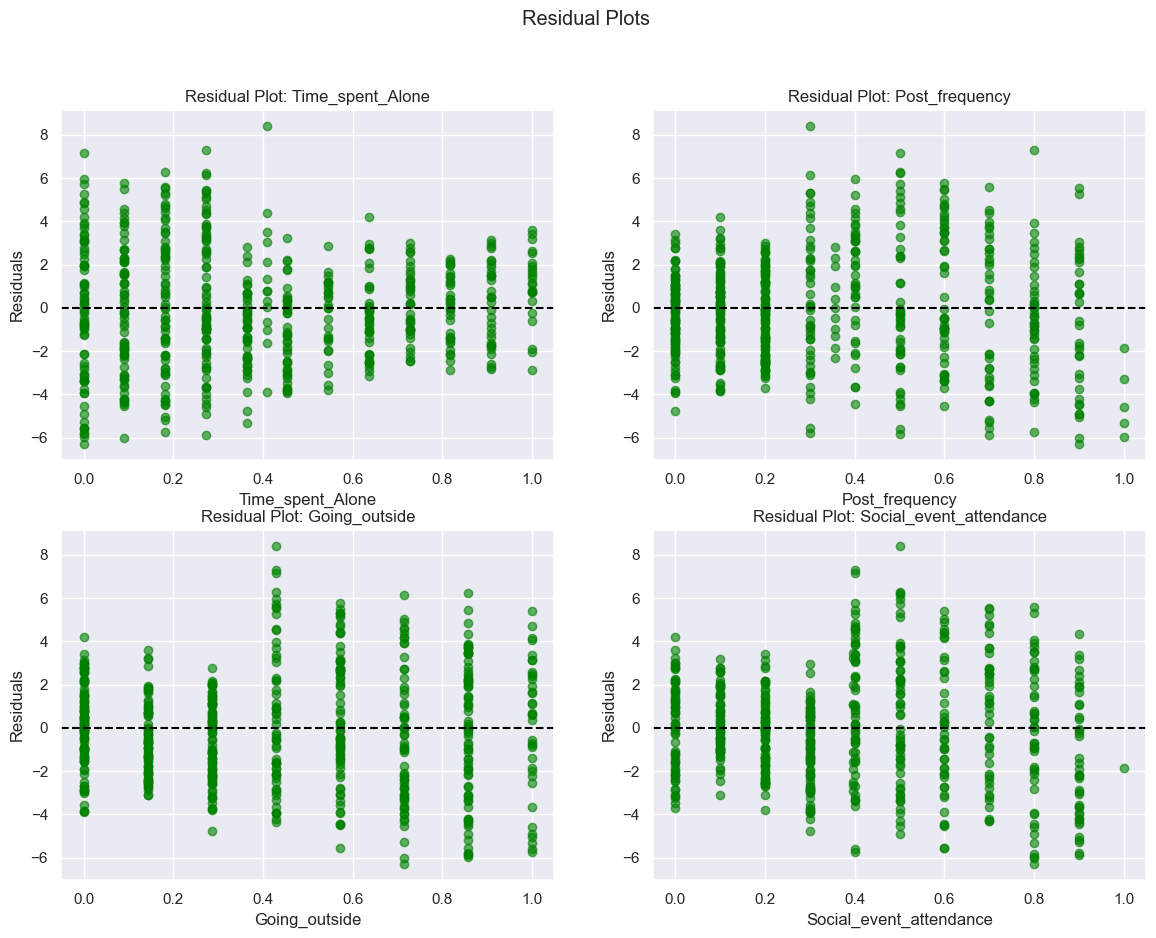

In [728]:
# Create subplots for prediction and residuals
fig_preds, axs_preds = plt.subplots(2, 2, figsize=(14, 10))
fig_resid, axs_resid = plt.subplots(2, 2, figsize=(14, 10))

axs_preds = axs_preds.flatten()
axs_resid = axs_resid.flatten()

for i, predictor in enumerate(predictors):
    ax_pred = axs_preds[i]
    ax_resid = axs_resid[i]

    transformed_df = pre_df.copy()[predictors]
    X = transformed_df
    y = pre_df['Friends_circle_size']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

    x_vals = np.linspace(X_test[predictor].min(), X_test[predictor].max(), 100)

    # "All else being equal" - fix data for other predictors
    fixed_data = pd.DataFrame({
        col: [X_test[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })

    # Train Ridge model
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)

    # Predictions for plotting
    y_pred = model.predict(X_test)

    # --- Plot predictions ---
    # Plot predicted values
    ax_pred.scatter(
        X_test[predictor],
        y_pred,
        alpha=0.6,
        color='blue',
        label='Predictions'
    )

    # Get predictions over a range for the regression line
    y_hat = model.predict(fixed_data)

    # Plot regression line
    ax_pred.plot(x_vals, y_hat, color='red', label='E(y)', linestyle='--')

    # Plot confidence interval
    ci_lower, ci_upper = ridge_bootstrap(X_train, y_train, fixed_data)
    ax_pred.fill_between(x_vals, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')

    # Plot prediction interval
    pi_lower, pi_upper = ridge_bootstrap(X_train, y_train, fixed_data, given_model=ridge_model, y_hat=y_hat, interval="prediction")
    ax_pred.fill_between(x_vals, pi_lower, pi_upper, color='blue', alpha=0.2, label='95% CI')

    ax_pred.set_title(f'Ridge Regression on {predictor}')
    ax_pred.set_xlabel(predictor)
    ax_pred.set_ylabel('Friends Circle Size')
    ax_pred.legend()

    # --- Plot residuals ---
    residuals = y_test - y_pred
    ax_resid.scatter(X_test[predictor], residuals, alpha=0.6, color='green')
    ax_resid.axhline(0, color='black', linestyle='--')
    ax_resid.set_title(f'Residual Plot: {predictor}')
    ax_resid.set_xlabel(predictor)
    ax_resid.set_ylabel('Residuals')

handles, labels = axs_preds[0].get_legend_handles_labels()
fig_preds.legend(handles, labels, loc='upper center', ncol=4, frameon=False)

fig_resid.suptitle("Residual Plots")
plt.show()


## Plot Segmented Ridge Regression with CI & PI

### Compute the Optimal Segment Breakpoints

In [729]:
# Create empty dataframe with predictors as columns and first row filled with NA
breakpoints = pd.DataFrame(np.nan, columns=predictors, index=[1])

# Fill first row with optimal breakpoints.
for predictor in predictors:
    breakpoints[predictor] = find_optimal_breakpoint(X_test[predictor], y_pred)

breakpoints

,Time_spent_Alone,Post_frequency,Going_outside,Social_event_attendance
1,0.363636,0.3,0.428571,0.4


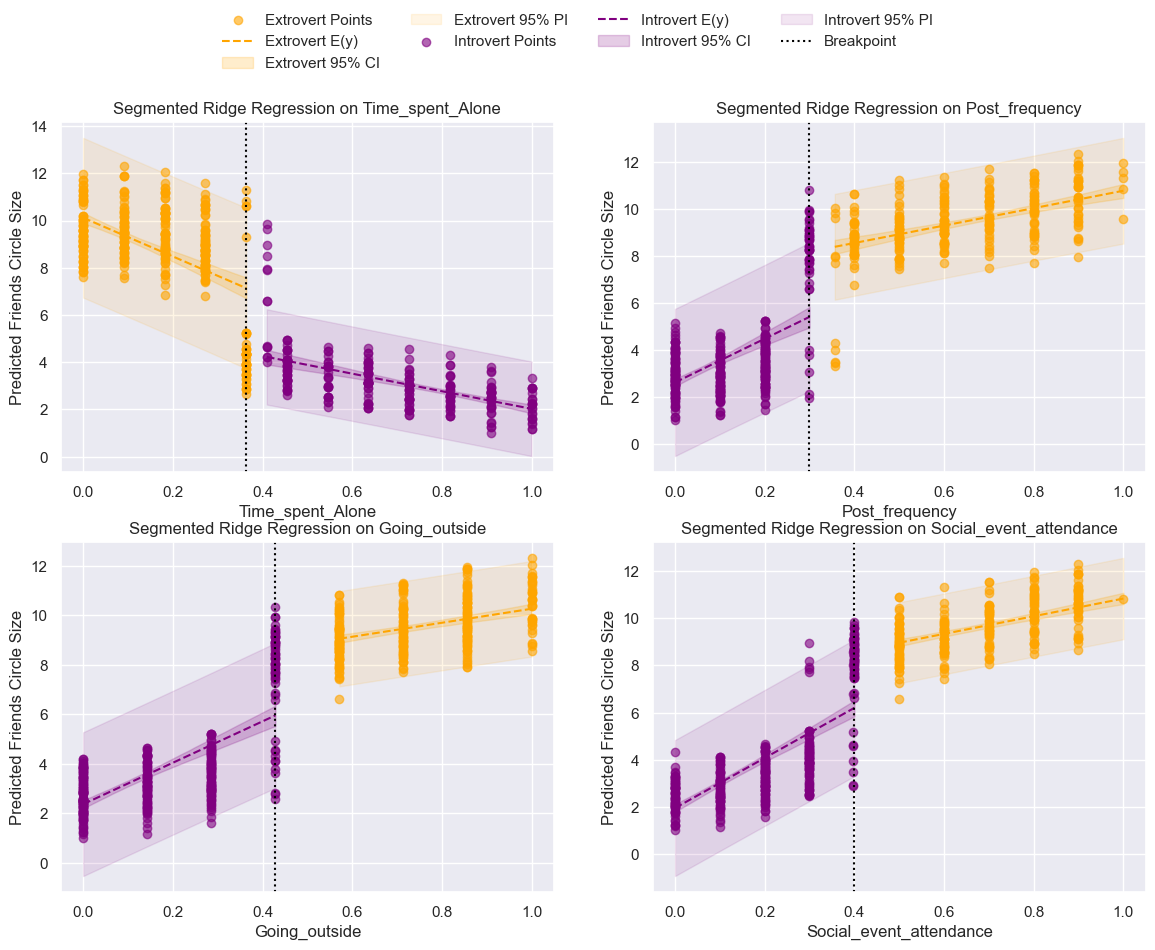

In [730]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

segments = {
    1: {
        "label": Personality.extrovert.value[1],
        "color": "orange"
    },
    0: {
        "label": Personality.introvert.value[1],
        "color": "purple"
    }
}

# Add personality to X_test for coloring segments
categorical = ["Personality"]
columns = predictors.copy()
columns.extend(categorical)
X = pre_df.copy()[columns]
y = pre_df['Friends_circle_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

# L2 regularization rate
alpha = 1.0

for i, predictor in enumerate(predictors):
    ax = axs[i]
    bp = breakpoints[predictor][1]

    # Segment masks
    low_mask = X_test[predictor] <= bp
    high_mask = X_test[predictor] > bp

    for mask in [low_mask, high_mask]:
        segment_data = X_test[mask].copy()
        X = segment_data[[predictor]].copy()
        y = y_pred[mask].copy()

        # Fit ridge model
        model = Ridge(alpha=alpha)
        model.fit(X, y)

        # Generate range of x values for predictions
        x_vals = np.linspace(X[predictor].min(), X[predictor].max(), 100).reshape(-1, 1)
        x_vals_df = pd.DataFrame(x_vals, columns=[predictor])

        y_hat = model.predict(x_vals_df)

        ci_lower, ci_upper = ridge_bootstrap(
            X,
            y,
            fixed_data=x_vals_df,
            interval="confidence"
        )

        pi_lower, pi_upper = ridge_bootstrap(
            X,
            y,
            fixed_data=x_vals_df,
            given_model=model,
            y_hat=y_hat,
            interval="prediction",
        )

        # Get personality for color/label
        personality = segment_data["Personality"].mode()[0]
        color = segments[personality]["color"]
        label = segments[personality]["label"]

        # Plot data points
        ax.scatter(
            X[predictor],
            y,
            alpha=0.6,
            color=color,
            label=f"{label} Points"
        )

        # Plot regression line
        ax.plot(
            x_vals,
            y_hat,
            color=color,
            linestyle='--',
            label=f'{label} E(y)'
        )

        # Confidence interval
        ax.fill_between(
            x_vals.ravel(),
            ci_lower,
            ci_upper,
            color=color,
            alpha=0.2,
            label=f'{label} 95% CI'
        )

        # Prediction interval
        ax.fill_between(
            x_vals.ravel(),
            pi_lower,
            pi_upper,
            color=color,
            alpha=0.1,
            label=f'{label} 95% PI'
        )

    ax.axvline(bp, color='black', linestyle=':', label='Breakpoint')
    ax.set_title(f'Segmented Ridge Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')

# Avoid duplicate legends
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False)
plt.show()

# Prediction
---

In [731]:
from numpy import median

column_range: dict[str, dict[ str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(orig_pre_df[column]),
        "median": median(orig_pre_df[column]),
        "min": min(orig_pre_df[column])
    }

In [732]:
B = ridge_model.coef_
B_labels = X_train.columns[:-1]  # All except Personality
B_df = pd.DataFrame(index=B_labels, data=B, columns=["Coefficient"])
B_df.to_csv("./data/coefficient_dataframe.csv")

def estimate(x, idx):
    coefficient: float = B[idx]
    proportion: float = x / column_range[B_labels[idx]]["max"]
    return coefficient * proportion

time_alone = lambda x: estimate(x, 0)
post_freq = lambda x: estimate(x, 1)
outside = lambda x: estimate(x, 2)
events = lambda x: estimate(x, 3)

y = time_alone(1) + post_freq(10) + outside(10) + events(10)
y

np.float64(10.555684469444813)

# Application
---

In [ ]:
%%writefile app.py
import streamlit as st
from numpy import median
import pandas as pd

st.title("Friend Circle Size Estimator")
st.markdown(
    """ 
    This app allows for educators to estimate the number a friends a student may have based on
    self-reported time spent alone, posting online, going outside, attending events, and
    attending outside events.
    """
)

pre_df = pd.read_csv("data/preprocessing_dataframe.csv")
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
column_range: dict[str, dict[str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(pre_df[column]),
        "median": median(pre_df[column]),
        "min": min(pre_df[column])
    }

humanized_label = {
    "Time_spent_Alone": "Hours spent alone",
    "Post_frequency": "Number of posts online",
    "Going_outside": "Number of instances going outside",
    "Social_event_attendance": "Number of social events attended"
}

result = {}
for column in predictors:
    value = st.slider(
        humanized_label[column],
        min_value=column_range[column]["min"],
        max_value=column_range[column]["max"],
        value=column_range[column]["median"],
    )
    result[column] = value

coef_df = pd.read_csv("data/coefficient_dataframe.csv", index_col=0)


def estimate(x, column):
    coefficient: float = coef_df.loc[column]
    proportion: float = x / column_range[column]["max"]
    return coefficient * proportion


def get_estimate():
    estimated = 0.0
    for column in predictors:
        estimated += estimate(result[column], column)
    return round(estimated.loc["Coefficient"], 2)


if st.button("Estimate"):
    st.text("{} friends".format(get_estimate()))


Overwriting app.py
